# Thesis: Training an Adapter for Cruise

This notebook documents the workflow for training a YOLO-based adapter model tailored for cruise applications. The process includes dataset preparation, configuration file creation, model training, and result management.

## Install Required Libraries

In this step, we will install the necessary libraries for training and evaluation. This includes the `ultralytics` package, which provides the YOLO implementation used in this workflow.

In [1]:
%%bash
ls /kaggle/input/train-thesis
mkdir -p dataset
cp -r /kaggle/input/*/* dataset/

classes.txt
test
train
valid


In [2]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.7 MB/s eta 0:00:00


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir models

<IPython.core.display.Javascript object>

In [4]:
from ultralytics import YOLO
import os
import cv2
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import shutil
import random
warnings.filterwarnings("ignore", category=RuntimeWarning)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Copy dataset from dataset save with kaggle

## Create YAML Configuration for Training

This section describes how to automatically generate a `data.yaml` configuration file required for YOLO training. The script reads class names from `classes.txt`, sets up dataset paths, and writes the configuration in YAML format.

In [5]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': 'dataset',
      'train': 'train/images',
      'val': 'valid/images',
      'test': 'test/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = 'dataset/classes.txt'
path_to_data_yaml = 'data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat data.yaml

Created config file at data.yaml

File contents:

path: dataset
train: train/images
val: valid/images
test: test/images
nc: 21
names:
- person
- bicycle
- car
- motorcycle
- bus
- truck
- stop sign
- other-vehicle
- crosswalk
- red light
- yellow light
- green light
- Speed limit 30km-h
- Speed limit 40km-h
- Speed limit 50km-h
- Speed limit 60km-h
- Speed limit 70km-h
- Speed limit 80km-h
- End of speed limit 60km-h
- End of speed limit 70km-h
- End of speed limit 80km-h


# Data Visualization

This section demonstrates how to visualize the training data with bounding boxes. The code will:

1. Load a random image from the training dataset
2. Read its corresponding label file
3. Draw bounding boxes and class labels on the image
4. Display the annotated image using matplotlib

This visualization helps verify that:
- Images are loading correctly
- Label files are properly formatted
- Bounding box coordinates are accurate
- Class IDs are valid

The visualization uses:
- OpenCV for image processing and drawing
- Matplotlib for display
- Green bounding boxes with class labels
- RGB color format for proper display

You can run the next cell to see a random training example with its annotations.


In [6]:
def load_classes(classes_path):
    """
    Load class names from classes.txt file.
    
    Args:
        classes_path (str): Path to the classes.txt file
    
    Returns:
        list: List of class names
    """
    if not os.path.exists(classes_path):
        print(f"Classes file {classes_path} not found!")
        return []
    
    with open(classes_path, 'r') as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

In [7]:
def visualize_random_samples(data_path, num_samples=6):
    """
    Visualize random samples from the dataset with bounding boxes in a 2x3 subplot.

    Args:
        data_path (str): Path to the dataset directory
        num_samples (int): Number of random samples to visualize (default=6 for 2x3 grid)
    """
    # Load class names
    classes_path = os.path.join(data_path, 'classes.txt')
    class_names = load_classes(classes_path)
    if not class_names:
        print("No class names loaded, using default class IDs.")
    
    # Load the images and labels
    images_path = os.path.join(data_path, 'train', 'images')
    labels_path = os.path.join(data_path, 'train', 'labels')

    # Get list of image files
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Select random images
    selected_images = random.sample(image_files, min(num_samples, len(image_files)))

    # Create a 2x3 subplot grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()  # Flatten the 2x3 array for easier iteration

    for idx, random_image in enumerate(selected_images):
        image_path = os.path.join(images_path, random_image)
        label_path = os.path.join(labels_path, random_image.replace('.jpg', '.txt')
                                 .replace('.jpeg', '.txt').replace('.png', '.txt'))

        # Read and process the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Read labels and draw boxes
        num_objects = 0
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            height, width = img.shape[:2]
            for line in lines:
                class_id, x_center, y_center, w, h = map(float, line.strip().split())
                class_id = int(class_id)
                
                # Get class name or fallback to class ID
                class_label = class_names[class_id] if class_id < len(class_names) else f'Class {class_id}'

                # Convert normalized coordinates to pixel coordinates
                x1 = int((x_center - w/2) * width)
                y1 = int((y_center - h/2) * height)
                x2 = int((x_center + w/2) * width)
                y2 = int((y_center + h/2) * height)

                # Draw rectangle
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Add class label
                cv2.putText(img, class_label, (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                num_objects += 1

        # Display image in subplot
        axes[idx].imshow(img)
        axes[idx].set_title(f'Image: {random_image}\nObjects: {num_objects}')
        axes[idx].axis('off')

        # Print image details
        print(f'Image {idx+1}:')
        print(f'Image shape: {img.shape}')
        print(f'Image path: {image_path}')
        print(f'Number of objects detected: {num_objects}\n')

    # Hide empty subplots if fewer images than num_samples
    for idx in range(len(selected_images), 6):
        axes[idx].axis('off')
        axes[idx].set_visible(False)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

Image 1:
Image shape: (720, 1280, 3)
Image path: dataset/train/images/thesis-000942.jpg
Number of objects detected: 14

Image 2:
Image shape: (720, 1280, 3)
Image path: dataset/train/images/thesis-004483.jpg
Number of objects detected: 3

Image 3:
Image shape: (720, 1280, 3)
Image path: dataset/train/images/thesis-003963.jpg
Number of objects detected: 7

Image 4:
Image shape: (720, 1280, 3)
Image path: dataset/train/images/thesis-001276.jpg
Number of objects detected: 8

Image 5:
Image shape: (720, 1280, 3)
Image path: dataset/train/images/thesis-003928.jpg
Number of objects detected: 5

Image 6:
Image shape: (720, 1280, 3)
Image path: dataset/train/images/thesis-001777.jpg
Number of objects detected: 6



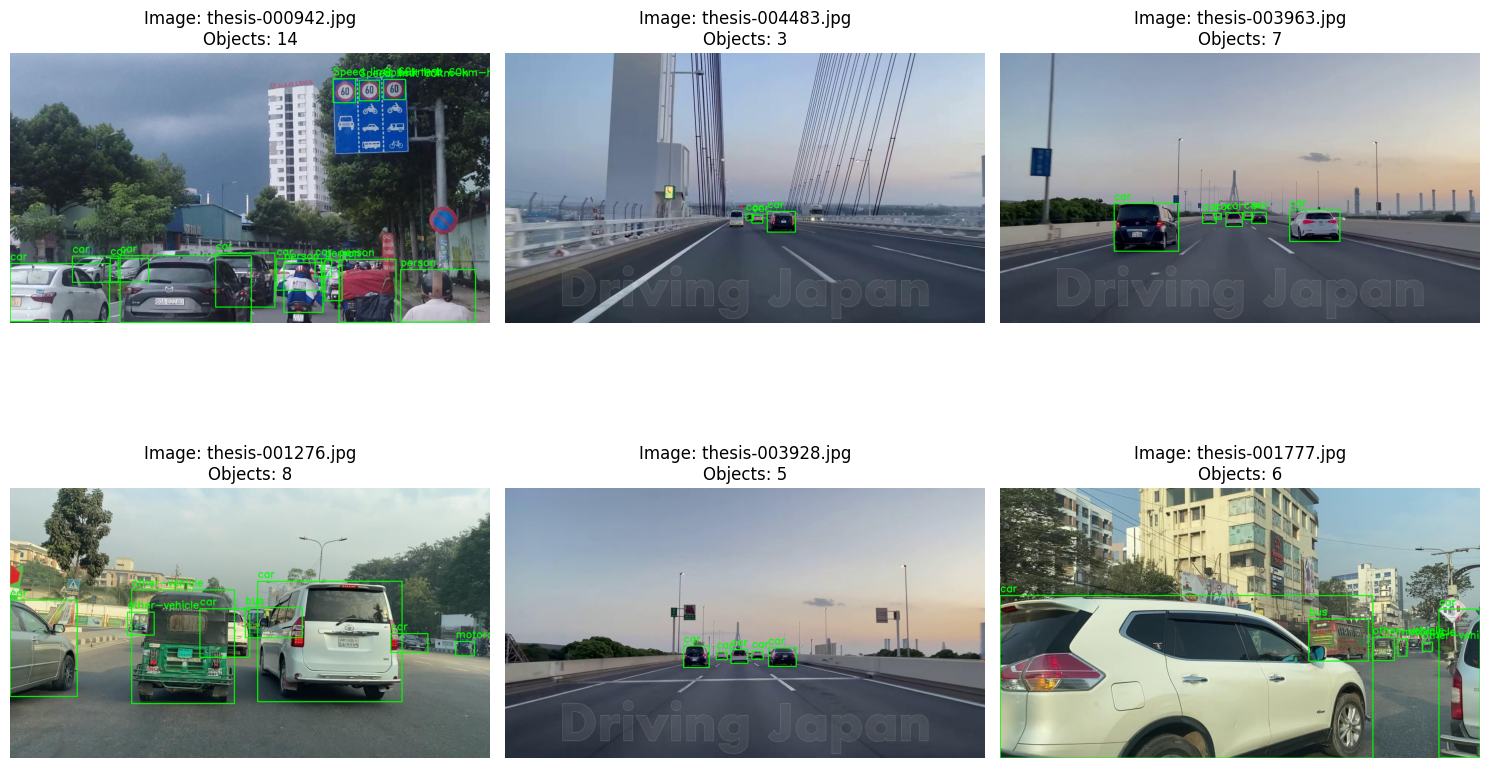

In [8]:
data_path = 'dataset'
visualize_random_samples(data_path, num_samples=6)

## Start YOLO model training

The model and training parameters are defined in the cell below.
Please run the next cell to begin training.

In [9]:
# Load pretrained model (better starting point than from scratch)
model = YOLO("yolo11n.pt")  # or "yolo11n.pt" for standard YOLOv11

100%|██████████| 5.35M/5.35M [00:00<00:00, 71.3MB/s]


In [10]:
# # Train the model with optimized parameters
model.train(
    data="data.yaml",       # Path to dataset config file
    epochs=250,             # Number of training epochs
    imgsz=640,              # Input image size (square: 640x640)
    batch=16,               # Batch size (adjust based on GPU memory)
    device=[0, 1],          # Use GPU 0 and GPU 1
    patience=100,            # Stop early if no improvement in 50 epochs
    project="models",
    optimizer="auto",       # Let YOLO choose the best optimizer
        lr0=0.005                # Initial learning rate
)


Ultralytics 8.3.158 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=250, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True

100%|██████████| 755k/755k [00:00<00:00, 16.6MB/s]


Overriding model.yaml nc=80 with nc=21

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /kaggle/working/dataset/train/labels... 7109 images, 5 backgrounds, 0 corrupt: 100%|██████████| 7109/7109 [00:05<00:00, 1406.15it/s]


train: /kaggle/working/dataset/train/images/frame_2413.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/frame_4241.jpg: 1 duplicate labels removed
train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 792.5±762.0 MB/s, size: 121.1 KB)


val: Scanning /kaggle/working/dataset/valid/labels... 1824 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1824/1824 [00:01<00:00, 1558.12it/s]


val: /kaggle/working/dataset/valid/images/frame_0274.jpg: 1 duplicate labels removed
val: /kaggle/working/dataset/valid/images/frame_4122.jpg: 1 duplicate labels removed
val: New cache created: /kaggle/working/dataset/valid/labels.cache
Plotting labels to models/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to models/train
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      1.39G      1.031      2.379     0.9986         43        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:12<00:00,  9.48it/s]


                   all       1824       8387      0.599      0.311      0.284        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250       1.4G     0.9906      1.313          1         14        640: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.44it/s]


                   all       1824       8387      0.474      0.377      0.311       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      1.41G       1.04      1.268      1.008         29        640: 100%|██████████| 445/445 [01:21<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.57it/s]


                   all       1824       8387      0.537      0.272      0.275      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      1.47G      1.057       1.22      1.019         38        640: 100%|██████████| 445/445 [01:20<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.42it/s]


                   all       1824       8387      0.492      0.261      0.298      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      1.49G      1.006      1.099      1.001         44        640: 100%|██████████| 445/445 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.94it/s]


                   all       1824       8387      0.495      0.406      0.322      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250       1.5G     0.9762     0.9892     0.9907         19        640: 100%|██████████| 445/445 [01:21<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.19it/s]


                   all       1824       8387      0.591      0.349      0.356      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      1.51G     0.9651     0.9366     0.9902         25        640: 100%|██████████| 445/445 [01:21<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.93it/s]


                   all       1824       8387      0.575      0.375      0.375      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      1.51G     0.9277     0.8793     0.9707         11        640: 100%|██████████| 445/445 [01:21<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.52it/s]


                   all       1824       8387      0.475      0.402       0.36      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      1.53G     0.9109     0.8261     0.9711         10        640: 100%|██████████| 445/445 [01:20<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.70it/s]


                   all       1824       8387      0.635      0.354       0.36      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      1.54G     0.9078     0.8162     0.9669         26        640: 100%|██████████| 445/445 [01:21<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.75it/s]


                   all       1824       8387      0.603       0.36      0.387      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      1.54G     0.8958     0.7895     0.9617         24        640: 100%|██████████| 445/445 [01:21<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.07it/s]


                   all       1824       8387       0.55      0.441      0.411      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      1.55G     0.8841      0.759     0.9573         27        640: 100%|██████████| 445/445 [01:21<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.98it/s]


                   all       1824       8387      0.533      0.415      0.416      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250      1.57G     0.8662     0.7499     0.9504         33        640: 100%|██████████| 445/445 [01:21<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.06it/s]


                   all       1824       8387      0.597      0.402      0.403      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      1.58G     0.8663     0.7417     0.9518         31        640: 100%|██████████| 445/445 [01:21<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.03it/s]


                   all       1824       8387      0.572      0.481      0.442      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      1.59G     0.8608      0.731     0.9457         20        640: 100%|██████████| 445/445 [01:20<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.50it/s]


                   all       1824       8387       0.57      0.468      0.439      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      1.59G     0.8519     0.7271     0.9473         10        640: 100%|██████████| 445/445 [01:20<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.64it/s]


                   all       1824       8387      0.649      0.399      0.446      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      1.61G     0.8406     0.7089     0.9394         14        640: 100%|██████████| 445/445 [01:21<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.60it/s]


                   all       1824       8387      0.546      0.443      0.408      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      1.62G      0.838     0.6949      0.938         19        640: 100%|██████████| 445/445 [01:21<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.06it/s]


                   all       1824       8387      0.623      0.423      0.446      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      1.62G     0.8195     0.6767     0.9309         39        640: 100%|██████████| 445/445 [01:21<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.65it/s]


                   all       1824       8387      0.674      0.424      0.459      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      1.63G     0.8088     0.6689     0.9295         27        640: 100%|██████████| 445/445 [01:21<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.06it/s]


                   all       1824       8387      0.582      0.441      0.429      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      1.64G     0.8118     0.6723     0.9286         53        640: 100%|██████████| 445/445 [01:21<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.71it/s]


                   all       1824       8387      0.646      0.436      0.459       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      1.66G     0.8215     0.6764     0.9361         13        640: 100%|██████████| 445/445 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.82it/s]


                   all       1824       8387       0.64      0.455      0.503      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      1.67G     0.8211     0.6654     0.9334         40        640: 100%|██████████| 445/445 [01:21<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.57it/s]


                   all       1824       8387      0.569       0.47      0.455      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      1.67G     0.8006     0.6556     0.9253          6        640: 100%|██████████| 445/445 [01:20<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.95it/s]


                   all       1824       8387      0.651      0.461      0.504       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      1.69G     0.8014     0.6518     0.9239         34        640: 100%|██████████| 445/445 [01:20<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.93it/s]


                   all       1824       8387      0.613      0.497      0.524      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250       1.7G      0.786     0.6384      0.919         44        640: 100%|██████████| 445/445 [01:20<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.09it/s]


                   all       1824       8387      0.534      0.436      0.473      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      1.71G     0.7824     0.6349     0.9153         18        640: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.88it/s]


                   all       1824       8387      0.648      0.458      0.474      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      1.71G     0.7889     0.6314     0.9219         19        640: 100%|██████████| 445/445 [01:20<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.48it/s]


                   all       1824       8387       0.65      0.498      0.507      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      1.72G     0.7926     0.6431     0.9238         23        640: 100%|██████████| 445/445 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.70it/s]


                   all       1824       8387       0.72      0.457      0.523      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      1.74G     0.7823     0.6261     0.9203         18        640: 100%|██████████| 445/445 [01:20<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.83it/s]


                   all       1824       8387      0.641      0.463      0.474      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      1.74G     0.7827     0.6204     0.9153         28        640: 100%|██████████| 445/445 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.94it/s]


                   all       1824       8387      0.558       0.48      0.447      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      1.75G     0.7738     0.6168     0.9174         17        640: 100%|██████████| 445/445 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.76it/s]


                   all       1824       8387      0.582      0.485      0.493      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      1.76G     0.7821     0.6196      0.916         40        640: 100%|██████████| 445/445 [01:21<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.99it/s]


                   all       1824       8387      0.544      0.549      0.496      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      1.77G     0.7769     0.6124     0.9193         21        640: 100%|██████████| 445/445 [01:21<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.39it/s]


                   all       1824       8387      0.557      0.505      0.484      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      1.79G     0.7716     0.6134      0.916         40        640: 100%|██████████| 445/445 [01:20<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.78it/s]


                   all       1824       8387      0.659      0.476      0.513      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      1.79G     0.7777     0.6181      0.917         55        640: 100%|██████████| 445/445 [01:19<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.63it/s]


                   all       1824       8387      0.675      0.492      0.535      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250       1.8G     0.7693     0.6037     0.9134         34        640: 100%|██████████| 445/445 [01:21<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.88it/s]


                   all       1824       8387      0.598      0.482      0.486      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      1.82G     0.7576     0.5917     0.9103         21        640: 100%|██████████| 445/445 [01:21<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.70it/s]


                   all       1824       8387      0.567      0.469      0.498      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      1.82G     0.7677     0.5973     0.9112         42        640: 100%|██████████| 445/445 [01:21<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.07it/s]


                   all       1824       8387      0.636      0.483      0.506      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      1.83G     0.7635     0.5985     0.9109         36        640: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.20it/s]


                   all       1824       8387      0.537      0.486      0.489      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      1.85G     0.7602     0.5978     0.9073         16        640: 100%|██████████| 445/445 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.78it/s]


                   all       1824       8387      0.655      0.489      0.521      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      1.85G     0.7547     0.5967     0.9078         23        640: 100%|██████████| 445/445 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.50it/s]


                   all       1824       8387      0.688      0.484       0.55      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      1.87G       0.75     0.5815     0.9043         24        640: 100%|██████████| 445/445 [01:20<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.87it/s]


                   all       1824       8387      0.631      0.484      0.501      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      1.87G     0.7551     0.5876     0.9109         30        640: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.85it/s]


                   all       1824       8387      0.639      0.487      0.505      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      1.88G     0.7505     0.5856     0.9066         31        640: 100%|██████████| 445/445 [01:20<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.79it/s]


                   all       1824       8387      0.656      0.498      0.503      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      1.89G     0.7546     0.5835     0.9068         29        640: 100%|██████████| 445/445 [01:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.98it/s]


                   all       1824       8387      0.622      0.539      0.496      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      1.91G      0.738     0.5731     0.8998         17        640: 100%|██████████| 445/445 [01:21<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.62it/s]


                   all       1824       8387      0.707      0.506      0.536      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      1.91G      0.732     0.5674     0.9003          7        640: 100%|██████████| 445/445 [01:21<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.73it/s]


                   all       1824       8387      0.707       0.51      0.534      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250      1.92G     0.7406     0.5713     0.9022         34        640: 100%|██████████| 445/445 [01:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.51it/s]


                   all       1824       8387      0.679      0.522      0.535      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250      1.93G     0.7405     0.5777     0.9073         11        640: 100%|██████████| 445/445 [01:20<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.02it/s]


                   all       1824       8387      0.687      0.501      0.533      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250      1.94G      0.743     0.5747     0.9032         26        640: 100%|██████████| 445/445 [01:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.90it/s]


                   all       1824       8387      0.691      0.504      0.549      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250      1.95G     0.7434     0.5703     0.9017         35        640: 100%|██████████| 445/445 [01:21<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.96it/s]


                   all       1824       8387      0.661      0.549      0.529      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250      1.96G     0.7354     0.5643     0.9008         20        640: 100%|██████████| 445/445 [01:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.96it/s]


                   all       1824       8387      0.658      0.501      0.518      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250      1.98G     0.7437     0.5707      0.907         20        640: 100%|██████████| 445/445 [01:21<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.74it/s]


                   all       1824       8387      0.663      0.534      0.541      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250      1.98G      0.741     0.5762     0.9022         37        640: 100%|██████████| 445/445 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.58it/s]


                   all       1824       8387      0.677      0.492       0.55      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250      1.98G       0.74     0.5702     0.9003         32        640: 100%|██████████| 445/445 [01:20<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.61it/s]


                   all       1824       8387      0.696      0.502      0.544      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250         2G     0.7296     0.5581     0.9022         21        640: 100%|██████████| 445/445 [01:21<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.00it/s]


                   all       1824       8387      0.679      0.518      0.557      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      2.01G     0.7294     0.5656     0.8994         20        640: 100%|██████████| 445/445 [01:21<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.09it/s]


                   all       1824       8387      0.723      0.488      0.546      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250      2.02G     0.7305     0.5567     0.8971         53        640: 100%|██████████| 445/445 [01:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.08it/s]


                   all       1824       8387      0.617      0.522      0.536      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      2.03G     0.7272     0.5545     0.8983         13        640: 100%|██████████| 445/445 [01:21<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.56it/s]


                   all       1824       8387       0.62      0.527       0.53      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250      2.04G      0.718     0.5575     0.8945          7        640: 100%|██████████| 445/445 [01:21<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.06it/s]


                   all       1824       8387      0.703      0.499      0.541      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250      2.11G       0.72     0.5515     0.8971         16        640: 100%|██████████| 445/445 [01:20<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.32it/s]


                   all       1824       8387      0.567      0.609      0.557      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250      2.12G     0.7237     0.5546      0.899          9        640: 100%|██████████| 445/445 [01:20<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.38it/s]


                   all       1824       8387      0.617      0.564      0.542      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      2.12G     0.7238     0.5499     0.8987         30        640: 100%|██████████| 445/445 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.75it/s]


                   all       1824       8387      0.676      0.496      0.536      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250      2.14G     0.7163     0.5413     0.8945         33        640: 100%|██████████| 445/445 [01:22<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.09it/s]


                   all       1824       8387       0.69      0.496      0.536      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      2.15G     0.7077     0.5429     0.8927         46        640: 100%|██████████| 445/445 [01:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.08it/s]


                   all       1824       8387      0.649      0.536      0.544      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250      2.16G     0.7103     0.5455     0.8953         19        640: 100%|██████████| 445/445 [01:21<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.05it/s]


                   all       1824       8387      0.605      0.536      0.546        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250      2.16G     0.7078     0.5432     0.8929         10        640: 100%|██████████| 445/445 [01:21<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.49it/s]


                   all       1824       8387      0.689      0.528      0.558        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250      2.18G     0.7117     0.5441     0.8931         23        640: 100%|██████████| 445/445 [01:20<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.67it/s]


                   all       1824       8387        0.7      0.521      0.568      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250      2.19G     0.7078     0.5351     0.8933         29        640: 100%|██████████| 445/445 [01:20<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.00it/s]


                   all       1824       8387      0.792      0.516      0.568      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250       2.2G     0.6983     0.5301     0.8897         11        640: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.13it/s]


                   all       1824       8387      0.679      0.522      0.548      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250       2.2G     0.7229     0.5472     0.8972         24        640: 100%|██████████| 445/445 [01:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.23it/s]


                   all       1824       8387      0.577      0.533      0.543      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250      2.22G     0.7185     0.5445     0.8961         31        640: 100%|██████████| 445/445 [01:21<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.99it/s]


                   all       1824       8387      0.705      0.493      0.545      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      2.23G     0.7039     0.5303     0.8892         17        640: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.94it/s]


                   all       1824       8387      0.668      0.529      0.544      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250      2.24G     0.7081     0.5298     0.8922         32        640: 100%|██████████| 445/445 [01:20<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00,  9.96it/s]


                   all       1824       8387      0.643      0.511      0.559      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      2.24G     0.6961      0.525     0.8865         30        640: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.24it/s]


                   all       1824       8387      0.699      0.546       0.58      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250      2.25G     0.6987     0.5292      0.887         33        640: 100%|██████████| 445/445 [01:21<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.45it/s]


                   all       1824       8387      0.698      0.513      0.559      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250      2.27G     0.7017     0.5307     0.8873         20        640: 100%|██████████| 445/445 [01:21<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.04it/s]


                   all       1824       8387      0.684      0.523      0.555      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250      2.34G     0.7044     0.5348     0.8918          8        640: 100%|██████████| 445/445 [01:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.93it/s]


                   all       1824       8387      0.605      0.576      0.551      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      2.34G     0.6944     0.5261     0.8876         19        640: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.94it/s]


                   all       1824       8387      0.564      0.584      0.572      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250      2.35G     0.7035     0.5264     0.8889         27        640: 100%|██████████| 445/445 [01:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.69it/s]


                   all       1824       8387      0.629      0.627      0.582      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250      2.36G     0.6942     0.5193     0.8849         19        640: 100%|██████████| 445/445 [01:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.43it/s]


                   all       1824       8387       0.58      0.573      0.549        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250      2.38G     0.7052     0.5312      0.894         18        640: 100%|██████████| 445/445 [01:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.41it/s]


                   all       1824       8387      0.616      0.543      0.574      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250      2.38G     0.7102     0.5325     0.8908         28        640: 100%|██████████| 445/445 [01:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.35it/s]


                   all       1824       8387      0.603      0.552      0.564      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/250      2.39G     0.6881     0.5191     0.8844         23        640: 100%|██████████| 445/445 [01:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.58it/s]


                   all       1824       8387      0.679      0.534      0.562      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/250       2.4G     0.6967     0.5275     0.8879         21        640: 100%|██████████| 445/445 [01:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.49it/s]


                   all       1824       8387      0.709      0.508      0.573      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/250      2.42G     0.6969     0.5186     0.8871         16        640: 100%|██████████| 445/445 [01:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.06it/s]


                   all       1824       8387      0.648      0.528      0.571       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/250      2.42G     0.6985     0.5283     0.8908         18        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.78it/s]


                   all       1824       8387      0.642      0.543      0.558      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/250      2.43G      0.685     0.5116     0.8837         27        640: 100%|██████████| 445/445 [01:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.85it/s]


                   all       1824       8387      0.604      0.553      0.551      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/250      2.44G     0.6949     0.5225     0.8852         31        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.40it/s]


                   all       1824       8387      0.693      0.549      0.559      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/250      2.45G     0.6847     0.5115     0.8818         26        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.48it/s]


                   all       1824       8387      0.644      0.539       0.57      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/250      2.46G     0.6737     0.5081     0.8818         23        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.86it/s]


                   all       1824       8387      0.612      0.564      0.565      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/250      2.47G     0.6952       0.52     0.8878         42        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.73it/s]


                   all       1824       8387      0.724      0.534      0.568      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/250      2.49G     0.6817     0.5064     0.8818         10        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.72it/s]


                   all       1824       8387      0.695       0.55      0.572      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/250       2.5G     0.6795     0.5084     0.8823         18        640: 100%|██████████| 445/445 [01:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.29it/s]


                   all       1824       8387      0.719      0.536      0.577       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/250       2.5G     0.6866     0.5136     0.8857         21        640: 100%|██████████| 445/445 [01:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.29it/s]


                   all       1824       8387      0.714      0.525      0.576      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/250      2.51G     0.6771     0.5042     0.8771         35        640: 100%|██████████| 445/445 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.48it/s]


                   all       1824       8387       0.61       0.57      0.579      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/250      2.52G     0.6696     0.5008     0.8794         44        640: 100%|██████████| 445/445 [01:23<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.95it/s]


                   all       1824       8387      0.702      0.543       0.57      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/250      2.53G     0.6843     0.5097     0.8855         43        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.83it/s]


                   all       1824       8387      0.721      0.534      0.581      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/250      2.54G     0.6788     0.5078     0.8817         17        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.48it/s]


                   all       1824       8387      0.622      0.593      0.583      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/250      2.55G     0.6707     0.4999     0.8768         33        640: 100%|██████████| 445/445 [01:23<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.47it/s]


                   all       1824       8387      0.642      0.596      0.583      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/250      2.56G     0.6945     0.5138     0.8877         21        640: 100%|██████████| 445/445 [01:23<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.67it/s]


                   all       1824       8387       0.63      0.599      0.585      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/250      2.57G     0.6743     0.4962     0.8811         26        640: 100%|██████████| 445/445 [01:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.74it/s]


                   all       1824       8387      0.622      0.602      0.587      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/250      2.57G     0.6776     0.5035     0.8791         35        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.85it/s]


                   all       1824       8387      0.616      0.588      0.585      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/250      2.59G     0.6827      0.507     0.8828         46        640: 100%|██████████| 445/445 [01:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.74it/s]


                   all       1824       8387      0.605      0.597      0.591       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/250       2.6G     0.6615     0.4867     0.8771         14        640: 100%|██████████| 445/445 [01:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.87it/s]


                   all       1824       8387      0.728      0.533       0.59      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/250      2.61G     0.6748     0.4965     0.8808         32        640: 100%|██████████| 445/445 [01:21<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.48it/s]


                   all       1824       8387       0.59      0.598      0.592      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/250      2.61G     0.6691     0.4953     0.8769         18        640: 100%|██████████| 445/445 [01:21<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.07it/s]


                   all       1824       8387        0.6      0.605      0.593      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/250      2.63G     0.6712     0.4921     0.8779         43        640: 100%|██████████| 445/445 [01:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.88it/s]


                   all       1824       8387      0.722       0.54      0.589       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/250      2.64G     0.6671     0.4964     0.8762         28        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.96it/s]


                   all       1824       8387      0.598       0.59      0.599      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/250      2.65G     0.6648     0.4934     0.8768         12        640: 100%|██████████| 445/445 [01:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.55it/s]


                   all       1824       8387      0.604      0.591      0.596      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/250      2.65G     0.6648      0.489      0.875         15        640: 100%|██████████| 445/445 [01:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.51it/s]


                   all       1824       8387      0.608      0.591      0.593       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/250      2.67G     0.6721     0.4965     0.8797         21        640: 100%|██████████| 445/445 [01:23<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.70it/s]


                   all       1824       8387      0.626      0.604      0.591      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/250      2.68G     0.6708     0.4962      0.876         28        640: 100%|██████████| 445/445 [01:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.68it/s]


                   all       1824       8387      0.628      0.604      0.607      0.435


    115/250      2.68G      0.561     0.4121     0.8754         63        640:   0%|          | 1/445 [00:00<01:21,  5.42it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/250      2.69G     0.6643      0.489     0.8785         16        640: 100%|██████████| 445/445 [01:23<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.78it/s]


                   all       1824       8387      0.635      0.602       0.61      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/250      2.69G     0.6622     0.4856      0.875         12        640: 100%|██████████| 445/445 [01:21<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.31it/s]


                   all       1824       8387      0.638        0.6      0.608      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/250      2.71G      0.652      0.487     0.8695         17        640: 100%|██████████| 445/445 [01:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.97it/s]


                   all       1824       8387      0.667      0.596      0.609      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/250      2.72G     0.6718     0.4947     0.8764         19        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.82it/s]


                   all       1824       8387      0.677      0.593      0.614      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/250      2.73G     0.6642     0.4898     0.8737         26        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.80it/s]


                   all       1824       8387      0.691      0.587      0.614      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/250      2.74G     0.6663     0.4961     0.8748         22        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.83it/s]


                   all       1824       8387      0.686      0.589      0.613      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/250      2.75G     0.6598     0.4841     0.8751         14        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.39it/s]


                   all       1824       8387      0.668       0.59      0.612      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/250      2.76G     0.6572     0.4846     0.8735         21        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.98it/s]


                   all       1824       8387      0.639      0.601      0.613      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/250      2.78G     0.6663     0.4861     0.8736         16        640: 100%|██████████| 445/445 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.56it/s]


                   all       1824       8387      0.624      0.603      0.597      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/250      2.78G     0.6632     0.4837     0.8713         23        640: 100%|██████████| 445/445 [01:23<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.58it/s]


                   all       1824       8387      0.624      0.602      0.594      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/250      2.79G     0.6675     0.4868     0.8758         18        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00,  9.85it/s]


                   all       1824       8387      0.618      0.602      0.594      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/250       2.8G     0.6526     0.4834     0.8714         26        640: 100%|██████████| 445/445 [01:21<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.75it/s]


                   all       1824       8387      0.612      0.598      0.595      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/250      2.81G     0.6554      0.482     0.8705         27        640: 100%|██████████| 445/445 [01:23<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.90it/s]


                   all       1824       8387      0.606      0.608      0.595      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/250      2.81G     0.6571     0.4832     0.8739         28        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.87it/s]


                   all       1824       8387      0.611      0.608      0.611      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/250      2.83G     0.6554     0.4796     0.8706         32        640: 100%|██████████| 445/445 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.24it/s]


                   all       1824       8387      0.621      0.608      0.611      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/250      2.84G     0.6601     0.4872     0.8733         65        640: 100%|██████████| 445/445 [01:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.54it/s]


                   all       1824       8387      0.625      0.607      0.612       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/250      2.85G     0.6635     0.4828     0.8713         47        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.15it/s]


                   all       1824       8387      0.618      0.608      0.612      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/250      2.85G     0.6488     0.4758     0.8703         21        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.90it/s]


                   all       1824       8387       0.63      0.606      0.614      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/250      2.88G     0.6494     0.4723     0.8703         18        640: 100%|██████████| 445/445 [01:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.29it/s]


                   all       1824       8387      0.634      0.605      0.616      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/250      2.88G     0.6532     0.4785     0.8724          5        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.55it/s]


                   all       1824       8387      0.637      0.606      0.618      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/250      2.89G     0.6471     0.4713     0.8687         24        640: 100%|██████████| 445/445 [01:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.75it/s]


                   all       1824       8387      0.638      0.607      0.619      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/250      2.89G     0.6411     0.4683     0.8681         20        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.43it/s]


                   all       1824       8387      0.633      0.609      0.621      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/250      2.91G      0.652     0.4703     0.8735         22        640: 100%|██████████| 445/445 [01:23<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.07it/s]


                   all       1824       8387      0.625      0.611      0.622      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/250      2.92G     0.6541      0.477     0.8713         17        640: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.32it/s]


                   all       1824       8387      0.624      0.611      0.622      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/250      2.93G     0.6476     0.4712     0.8678         26        640: 100%|██████████| 445/445 [01:21<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.65it/s]


                   all       1824       8387      0.628      0.609      0.623      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/250      2.93G     0.6495       0.47     0.8703         28        640: 100%|██████████| 445/445 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.00it/s]


                   all       1824       8387      0.631      0.608      0.623      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/250      2.95G     0.6483     0.4703     0.8664         19        640: 100%|██████████| 445/445 [01:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.16it/s]


                   all       1824       8387      0.635      0.608      0.621      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/250      2.96G     0.6431      0.465     0.8682          9        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.84it/s]


                   all       1824       8387      0.631      0.608      0.621      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/250      2.97G     0.6382     0.4715     0.8648         17        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.62it/s]


                   all       1824       8387      0.636      0.614      0.621      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/250      2.97G     0.6428     0.4665     0.8676         20        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.60it/s]


                   all       1824       8387      0.639      0.616      0.621      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/250      2.99G     0.6459     0.4713     0.8697         34        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.12it/s]


                   all       1824       8387      0.639      0.616       0.62      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/250         3G      0.641     0.4672     0.8664         20        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.61it/s]


                   all       1824       8387      0.638      0.617       0.62      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/250      3.01G     0.6423     0.4648     0.8696         14        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.76it/s]


                   all       1824       8387      0.642      0.616      0.621      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/250      3.01G     0.6341     0.4569     0.8689         27        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.91it/s]


                   all       1824       8387      0.643      0.614      0.621      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/250      3.03G     0.6396     0.4648     0.8647         18        640: 100%|██████████| 445/445 [01:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.47it/s]


                   all       1824       8387      0.655       0.61      0.621      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/250      3.04G     0.6447     0.4623     0.8647         36        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.12it/s]


                   all       1824       8387      0.657      0.611      0.621      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/250      3.05G      0.642      0.461     0.8688         32        640: 100%|██████████| 445/445 [01:24<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.81it/s]


                   all       1824       8387      0.649      0.614      0.621      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/250      3.05G     0.6442     0.4673     0.8668         29        640: 100%|██████████| 445/445 [01:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.56it/s]


                   all       1824       8387      0.644      0.616      0.621      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/250      3.07G     0.6312     0.4505     0.8646         43        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.91it/s]


                   all       1824       8387      0.643      0.616      0.621       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/250      3.08G     0.6358      0.461     0.8651         57        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.16it/s]


                   all       1824       8387      0.649      0.614      0.619      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/250      3.09G     0.6329     0.4552     0.8661         25        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.43it/s]


                   all       1824       8387      0.647      0.616      0.619      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/250      3.09G     0.6334     0.4545     0.8626         19        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.31it/s]


                   all       1824       8387       0.65      0.617       0.62      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/250      3.11G       0.64     0.4575     0.8668         20        640: 100%|██████████| 445/445 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.68it/s]


                   all       1824       8387      0.649      0.617       0.62      0.447


    158/250      3.11G     0.6453     0.4588     0.8459         81        640:   0%|          | 1/445 [00:00<01:05,  6.82it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/250      3.12G     0.6349      0.455     0.8642          5        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.49it/s]


                   all       1824       8387      0.652      0.619      0.621      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/250      3.13G     0.6417     0.4565     0.8694         24        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.14it/s]


                   all       1824       8387      0.655      0.618      0.621      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/250      3.13G     0.6415     0.4568     0.8675         10        640: 100%|██████████| 445/445 [01:23<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.47it/s]


                   all       1824       8387       0.65      0.618       0.62      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/250      3.15G     0.6237     0.4492     0.8634         15        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.74it/s]


                   all       1824       8387       0.65      0.617      0.621      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/250      3.16G     0.6307      0.449     0.8611         25        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.38it/s]


                   all       1824       8387      0.647      0.618      0.621      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/250      3.17G     0.6314      0.448     0.8651          9        640: 100%|██████████| 445/445 [01:23<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.75it/s]


                   all       1824       8387      0.649      0.618       0.62      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/250      3.17G     0.6349     0.4541     0.8651         30        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.00it/s]


                   all       1824       8387      0.658      0.617      0.622      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/250      3.19G     0.6125     0.4391     0.8611         34        640: 100%|██████████| 445/445 [01:24<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.69it/s]


                   all       1824       8387      0.656      0.618      0.622      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/250       3.2G     0.6233     0.4485     0.8627         17        640: 100%|██████████| 445/445 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.36it/s]


                   all       1824       8387       0.66      0.618      0.621      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/250      3.21G     0.6296     0.4489     0.8633         29        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.96it/s]


                   all       1824       8387      0.662      0.617       0.62      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/250      3.21G     0.6234     0.4442     0.8619         19        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.02it/s]


                   all       1824       8387      0.664      0.614      0.617      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/250      3.23G     0.6255     0.4506     0.8645         22        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.27it/s]


                   all       1824       8387      0.665      0.614      0.616      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/250      3.24G     0.6253     0.4444     0.8609         50        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.76it/s]


                   all       1824       8387      0.664      0.614      0.617      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/250      3.25G     0.6315     0.4509     0.8628         22        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.99it/s]


                   all       1824       8387      0.664      0.614      0.617      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/250      3.25G     0.6258     0.4451     0.8602         20        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.28it/s]


                   all       1824       8387      0.665      0.607      0.617      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/250      3.27G       0.62     0.4387     0.8605         39        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.52it/s]


                   all       1824       8387      0.668      0.606      0.616      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/250      3.28G     0.6221      0.438       0.86         46        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.99it/s]


                   all       1824       8387      0.671      0.606      0.616      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/250      3.29G     0.6204     0.4421     0.8619         21        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.68it/s]


                   all       1824       8387      0.672      0.606      0.615      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/250      3.29G     0.6141     0.4388     0.8595         35        640: 100%|██████████| 445/445 [01:24<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.15it/s]


                   all       1824       8387      0.674      0.604      0.615      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/250      3.31G     0.6066     0.4319     0.8556         42        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.64it/s]


                   all       1824       8387      0.674      0.604      0.618      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/250      3.32G     0.6161     0.4368      0.859         24        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.07it/s]


                   all       1824       8387      0.675      0.604      0.618      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/250      3.33G     0.6127     0.4366     0.8607         57        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.02it/s]


                   all       1824       8387      0.679      0.602      0.615      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/250      3.33G     0.6208     0.4397     0.8603         15        640: 100%|██████████| 445/445 [01:23<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.77it/s]


                   all       1824       8387      0.683        0.6      0.615      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/250      3.35G     0.6097     0.4308     0.8562         12        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.76it/s]


                   all       1824       8387      0.682      0.594      0.618      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/250      3.36G     0.6174     0.4355     0.8592         43        640: 100%|██████████| 445/445 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00,  9.81it/s]


                   all       1824       8387      0.685      0.594      0.617      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/250      3.37G     0.6152      0.439     0.8583         42        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.65it/s]


                   all       1824       8387      0.691      0.593      0.617      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/250      3.37G     0.6023       0.43     0.8579         13        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.69it/s]


                   all       1824       8387      0.694      0.591      0.618      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/250      3.39G      0.612     0.4308     0.8577          7        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00,  9.83it/s]


                   all       1824       8387      0.693       0.59      0.618      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/250       3.4G     0.6053      0.432     0.8572         34        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.66it/s]


                   all       1824       8387      0.692      0.588      0.619      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/250      3.41G     0.6058     0.4314       0.86          7        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.65it/s]


                   all       1824       8387       0.69      0.586      0.619      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/250      3.41G     0.6062      0.431     0.8579         13        640: 100%|██████████| 445/445 [01:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.42it/s]


                   all       1824       8387       0.69      0.589      0.619      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/250      3.43G     0.6073     0.4306      0.856          8        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.90it/s]


                   all       1824       8387      0.691      0.586       0.62      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/250      3.44G     0.6021     0.4234     0.8565         36        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.75it/s]


                   all       1824       8387      0.691      0.585      0.621      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/250      3.45G     0.5966     0.4229     0.8537         18        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.21it/s]


                   all       1824       8387      0.691      0.585      0.622      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/250      3.45G     0.6033      0.424     0.8576         21        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.68it/s]


                   all       1824       8387       0.69      0.585      0.624      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/250      3.46G      0.611     0.4318     0.8609         23        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.87it/s]


                   all       1824       8387       0.69      0.586      0.625      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/250      3.47G     0.5934     0.4181     0.8517         30        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.43it/s]


                   all       1824       8387      0.689      0.586      0.629      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/250      3.49G     0.6014     0.4197     0.8567         12        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.95it/s]


                   all       1824       8387      0.689      0.586      0.629      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/250      3.49G     0.6013     0.4187     0.8542         59        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.21it/s]


                   all       1824       8387      0.691      0.585      0.629      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/250      3.51G     0.6043     0.4235     0.8544         17        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.93it/s]


                   all       1824       8387      0.694      0.585      0.629      0.456


  0%|          | 0/445 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/250      3.52G     0.5986     0.4228     0.8534         20        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.74it/s]


                   all       1824       8387      0.693      0.585      0.629      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/250      3.53G      0.601     0.4232     0.8558         40        640: 100%|██████████| 445/445 [01:24<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00,  9.92it/s]


                   all       1824       8387      0.692      0.585       0.63      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/250      3.53G     0.6012     0.4193     0.8534         23        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.00it/s]


                   all       1824       8387      0.694      0.585       0.63      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/250      3.55G     0.5979     0.4161     0.8533         23        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.06it/s]


                   all       1824       8387      0.693      0.585       0.63      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/250      3.55G      0.594     0.4143      0.853         15        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.18it/s]


                   all       1824       8387      0.692      0.585      0.631      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/250      3.56G     0.5954     0.4173      0.854         43        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.00it/s]


                   all       1824       8387      0.694      0.585      0.631      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/250      3.57G     0.5918      0.415     0.8512         36        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.49it/s]


                   all       1824       8387      0.693      0.585      0.631      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/250      3.59G     0.5882     0.4094     0.8489         16        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.78it/s]


                   all       1824       8387      0.693      0.585       0.63      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/250      3.59G     0.5905     0.4132     0.8513         30        640: 100%|██████████| 445/445 [01:26<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.83it/s]


                   all       1824       8387      0.689      0.585      0.631      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/250       3.6G     0.5864     0.4094     0.8507         19        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.31it/s]


                   all       1824       8387      0.685      0.586      0.631      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/250      3.61G     0.5855     0.4111     0.8524         19        640: 100%|██████████| 445/445 [01:24<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.98it/s]


                   all       1824       8387      0.685      0.586       0.63      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/250      3.62G     0.5841      0.403      0.851         31        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.58it/s]


                   all       1824       8387      0.685      0.587       0.63      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/250      3.63G     0.5789     0.4079     0.8492         51        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.34it/s]


                   all       1824       8387      0.686      0.586      0.631      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/250      3.64G     0.5936      0.415     0.8511         36        640: 100%|██████████| 445/445 [01:23<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.45it/s]


                   all       1824       8387      0.685      0.589      0.631      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/250      3.65G     0.5889     0.4104     0.8505         28        640: 100%|██████████| 445/445 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.06it/s]


                   all       1824       8387      0.685      0.588      0.631      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/250      3.66G     0.5889     0.4098     0.8494         30        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.80it/s]


                   all       1824       8387      0.688      0.588      0.632      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/250      3.68G     0.5799     0.4017     0.8494         10        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.58it/s]


                   all       1824       8387      0.689      0.585      0.632       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/250      3.68G     0.5811     0.4052      0.848         22        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.12it/s]


                   all       1824       8387      0.688      0.588      0.632       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/250      3.69G     0.5834     0.4046     0.8498         31        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.90it/s]


                   all       1824       8387      0.687      0.588      0.633      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/250       3.7G     0.5771     0.4057     0.8468         45        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.25it/s]


                   all       1824       8387      0.685      0.588      0.632      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/250      3.72G     0.5831     0.4058     0.8529         18        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.88it/s]


                   all       1824       8387      0.687      0.587      0.631      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/250      3.72G     0.5755     0.3958     0.8478         28        640: 100%|██████████| 445/445 [01:23<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.93it/s]


                   all       1824       8387      0.685      0.588      0.631      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/250      3.73G     0.5852     0.4076     0.8526         13        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.83it/s]


                   all       1824       8387      0.686      0.588      0.631      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/250      3.74G     0.5791      0.399     0.8474         16        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.93it/s]


                   all       1824       8387      0.685      0.588      0.632      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/250      3.75G     0.5763      0.395     0.8478         33        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.35it/s]


                   all       1824       8387      0.687      0.588      0.633      0.464


  0%|          | 0/445 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/250      3.77G     0.5775     0.3988     0.8477         15        640: 100%|██████████| 445/445 [01:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.70it/s]


                   all       1824       8387      0.688      0.587      0.632      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/250      3.77G     0.5776     0.4011     0.8493         25        640: 100%|██████████| 445/445 [01:21<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.76it/s]


                   all       1824       8387      0.688      0.584      0.632      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/250      3.78G     0.5756     0.3974     0.8456         18        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.47it/s]


                   all       1824       8387      0.687      0.585      0.633      0.464


    226/250      3.78G     0.4596     0.3004     0.8271         58        640:   0%|          | 1/445 [00:00<01:00,  7.35it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/250      3.79G     0.5706     0.3926     0.8445         27        640: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.63it/s]


                   all       1824       8387      0.688      0.585      0.633       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/250       3.8G      0.573     0.3914     0.8461         42        640: 100%|██████████| 445/445 [01:22<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.42it/s]


                   all       1824       8387      0.688      0.585      0.634      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/250       3.8G     0.5816     0.3988     0.8515         54        640: 100%|██████████| 445/445 [01:23<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.82it/s]


                   all       1824       8387      0.688      0.588      0.634      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/250      3.82G     0.5644     0.3875      0.846         25        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.92it/s]


                   all       1824       8387      0.688      0.588      0.634      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/250      3.84G     0.5699     0.3916     0.8462         14        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.62it/s]


                   all       1824       8387      0.686      0.586      0.634      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/250      3.85G     0.5709     0.3916     0.8453         28        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.09it/s]


                   all       1824       8387      0.687      0.586      0.634       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/250      3.85G     0.5756     0.3947     0.8466         25        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.03it/s]


                   all       1824       8387      0.688      0.586      0.634       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/250      3.86G     0.5696     0.3899     0.8485         24        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.83it/s]


                   all       1824       8387      0.687      0.586      0.635      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/250      3.87G     0.5688     0.3903      0.848         38        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.92it/s]


                   all       1824       8387      0.684      0.588      0.634       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/250      3.88G     0.5625     0.3844     0.8452         15        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.05it/s]


                   all       1824       8387      0.684      0.589      0.634      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/250      3.88G     0.5569     0.3839     0.8433         29        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 11.03it/s]


                   all       1824       8387      0.683      0.589      0.635      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/250      3.91G      0.564      0.388     0.8444         20        640: 100%|██████████| 445/445 [01:23<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00,  9.80it/s]


                   all       1824       8387      0.685       0.59      0.636      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/250      3.92G     0.5584     0.3843     0.8437         16        640: 100%|██████████| 445/445 [01:23<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.69it/s]


                   all       1824       8387      0.682      0.588      0.636      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/250      3.93G     0.5528     0.3808     0.8421         14        640: 100%|██████████| 445/445 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.48it/s]


                   all       1824       8387      0.684       0.59      0.638      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/250      3.93G     0.5621     0.3823      0.843         21        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.66it/s]


                   all       1824       8387      0.683      0.589      0.638      0.463
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/250      3.95G     0.5359     0.3581     0.8277         11        640: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.57it/s]


                   all       1824       8387      0.683      0.588      0.638      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/250      3.96G     0.5291     0.3511     0.8253         11        640: 100%|██████████| 445/445 [01:20<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.04it/s]


                   all       1824       8387      0.683      0.589      0.638      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/250      3.96G     0.5295     0.3545     0.8265         12        640: 100%|██████████| 445/445 [01:21<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.82it/s]


                   all       1824       8387      0.683      0.589      0.638      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/250      3.96G     0.5309     0.3523     0.8281         10        640: 100%|██████████| 445/445 [01:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.81it/s]


                   all       1824       8387      0.681      0.589      0.638      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/250      3.98G     0.5202     0.3482     0.8247         13        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.32it/s]


                   all       1824       8387       0.68      0.588      0.638      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/250         4G     0.5288     0.3501     0.8231         12        640: 100%|██████████| 445/445 [01:21<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.54it/s]


                   all       1824       8387      0.675      0.584      0.638      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/250         4G     0.5276     0.3479     0.8263         12        640: 100%|██████████| 445/445 [01:21<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.89it/s]


                   all       1824       8387      0.671      0.583      0.638      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/250      4.01G     0.5179     0.3443     0.8209         13        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.69it/s]


                   all       1824       8387      0.672      0.583      0.639      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/250      4.02G     0.5222     0.3439     0.8227         11        640: 100%|██████████| 445/445 [01:20<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.68it/s]


                   all       1824       8387      0.673      0.582      0.638      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/250      4.03G     0.5197     0.3431      0.825         10        640: 100%|██████████| 445/445 [01:20<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:11<00:00, 10.02it/s]


                   all       1824       8387      0.695      0.592      0.642      0.466

250 epochs completed in 6.508 hours.
Optimizer stripped from models/train/weights/last.pt, 5.5MB
Optimizer stripped from models/train/weights/best.pt, 5.5MB

Validating models/train/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,586,247 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:10<00:00, 10.50it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1824       8387      0.695      0.592      0.642       0.47
                person        273        925       0.76       0.48      0.586      0.296
               bicycle         69         80      0.489      0.375      0.352      0.144
                   car       1674       5265      0.905        0.9      0.948      0.824
            motorcycle        151        247      0.736      0.599       0.65      0.352
                   bus        270        375      0.818      0.659      0.751      0.588
                 truck        461        607      0.857      0.909      0.941      0.871
             stop sign         90         90      0.982      0.989       0.99      0.865
         other-vehicle        250        734      0.815      0.629      0.737      0.485
           green light          6         10      0.636      0.874      0.777      0.511
    Speed limit 30km-h          2          2      0.778        0.5       0.62      0.274
    Speed limit 40km-

## Training Metrics Analysis

After training, we can analyze the model's performance metrics to understand its effectiveness. The following metrics are particularly important:

### Key Performance Indicators
- **mAP (mean Average Precision)**: Overall detection accuracy
- **Precision**: Ratio of true positives to all detections
- **Recall**: Ratio of true positives to all ground truth objects
- **F1-Score**: Harmonic mean of precision and recall

### Training Progress
- **Loss Curves**: Monitor training and validation loss
- **Learning Rate**: Track learning rate adjustments
- **Confusion Matrix**: Analyze detection errors

### Model Efficiency
- **Inference Speed**: Frames per second (FPS)
- **Model Size**: Memory footprint
- **FLOPs**: Computational complexity

The metrics will be visualized in the next cell to help evaluate the model's performance.


In [11]:
# Run validation and get detailed metrics
metrics = model.val()

# Extract and print key performance metrics
print("\n=== Model Performance Metrics ===")
print(f"mAP@0.5:        {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95:   {metrics.box.map:.4f}")
print(f"Precision (mp): {metrics.box.mp:.4f}")
print(f"Recall (mr):    {metrics.box.mr:.4f}")
print(f"F1-Score (avg): {sum(metrics.box.f1) / len(metrics.box.f1):.4f}")

# Print per-class metrics safely
print("\n=== Per-Class Metrics ===")
num_classes_with_metrics = len(metrics.box.p)
for i, cls_name in model.names.items():
    if i >= num_classes_with_metrics:
        print(f"{cls_name}: (no detection results)")
        continue
    precision = metrics.box.p[i]
    recall = metrics.box.r[i]
    f1_score = metrics.box.f1[i]
    print(f"{cls_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1_score:.4f}")

# Calculate and print inference speed
print("\n=== Inference Speed ===")
inference_time = metrics.speed['inference']  # milliseconds per image
print(f"Average inference time: {inference_time:.2f} ms")
print(f"FPS: {1000 / inference_time:.1f}")


Ultralytics 8.3.158 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,586,247 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1377.9±748.9 MB/s, size: 69.6 KB)


val: Scanning /kaggle/working/dataset/valid/labels.cache... 1824 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1824/1824 [00:00<?, ?it/s]

val: /kaggle/working/dataset/valid/images/frame_0274.jpg: 1 duplicate labels removed
val: /kaggle/working/dataset/valid/images/frame_4122.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 114/114 [00:12<00:00,  9.37it/s]


                   all       1824       8387      0.695      0.592      0.641      0.468
                person        273        925      0.758       0.48      0.584      0.297
               bicycle         69         80      0.488      0.375      0.352      0.144
                   car       1674       5265      0.906        0.9      0.949      0.824
            motorcycle        151        247      0.739      0.597      0.648      0.352
                   bus        270        375      0.818       0.66      0.751      0.588
                 truck        461        607      0.857      0.909      0.941      0.871
             stop sign         90         90      0.982      0.989       0.99      0.862
         other-vehicle        250        734      0.815      0.629      0.736      0.483
           green light          6         10      0.636      0.876      0.765      0.502
    Speed limit 30km-h          2          2      0.778        0.5       0.62      0.267
    Speed limit 40km-

## Copy Training Results to Save Server

This section demonstrates how to securely copy the `runs` directory containing training results to a remote save server. This ensures that your experiment outputs are backed up and accessible for further analysis or sharing.

In [12]:
!pip install -q gdown
!gdown 'https://drive.google.com/uc?id=1nQ0_w3uG8McFgPxt-kVS1RPW1aKpb2YS'
!chmod 400 /kaggle/working/gcp-key
!ssh -i /kaggle/working/gcp-key -o StrictHostKeyChecking=no trung@34.142.148.134 "rm -rf /home/trung/models"
!scp -i /kaggle/working/gcp-key -o StrictHostKeyChecking=no -r models trung@34.142.148.134:/home/trung/models
!echo "Done!"

Downloading...
From: https://drive.google.com/uc?id=1nQ0_w3uG8McFgPxt-kVS1RPW1aKpb2YS
To: /kaggle/working/gcp-key
100%|██████████████████████████████████████| 1.82k/1.82k [00:00<00:00, 8.17MB/s]

bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
val_batch1_pred.jpg                           100%  351KB 279.4KB/s   00:01    
PR_curve.png                                  100%  365KB 868.8KB/s   00:00    
val_batch1_labels.jpg                         100%  343KB   1.6MB/s   00:00    
R_curve.png                                   100%  428KB   1.9MB/s   00:00    
confusion_matrix.png                          100%  367KB   1.7MB/s   00:00    
val_batch2_labels.jpg                         100%  326KB   1.5MB/s   00:00    
P_curve.png                                   100%  460KB   2.1MB/s   00:00    
confusion_matrix_normalized.png               100%  411KB   1.9MB/s   00:00    
val_batch0_pred.jpg       

## Test Results Analysis

### Test Images Directory Structure



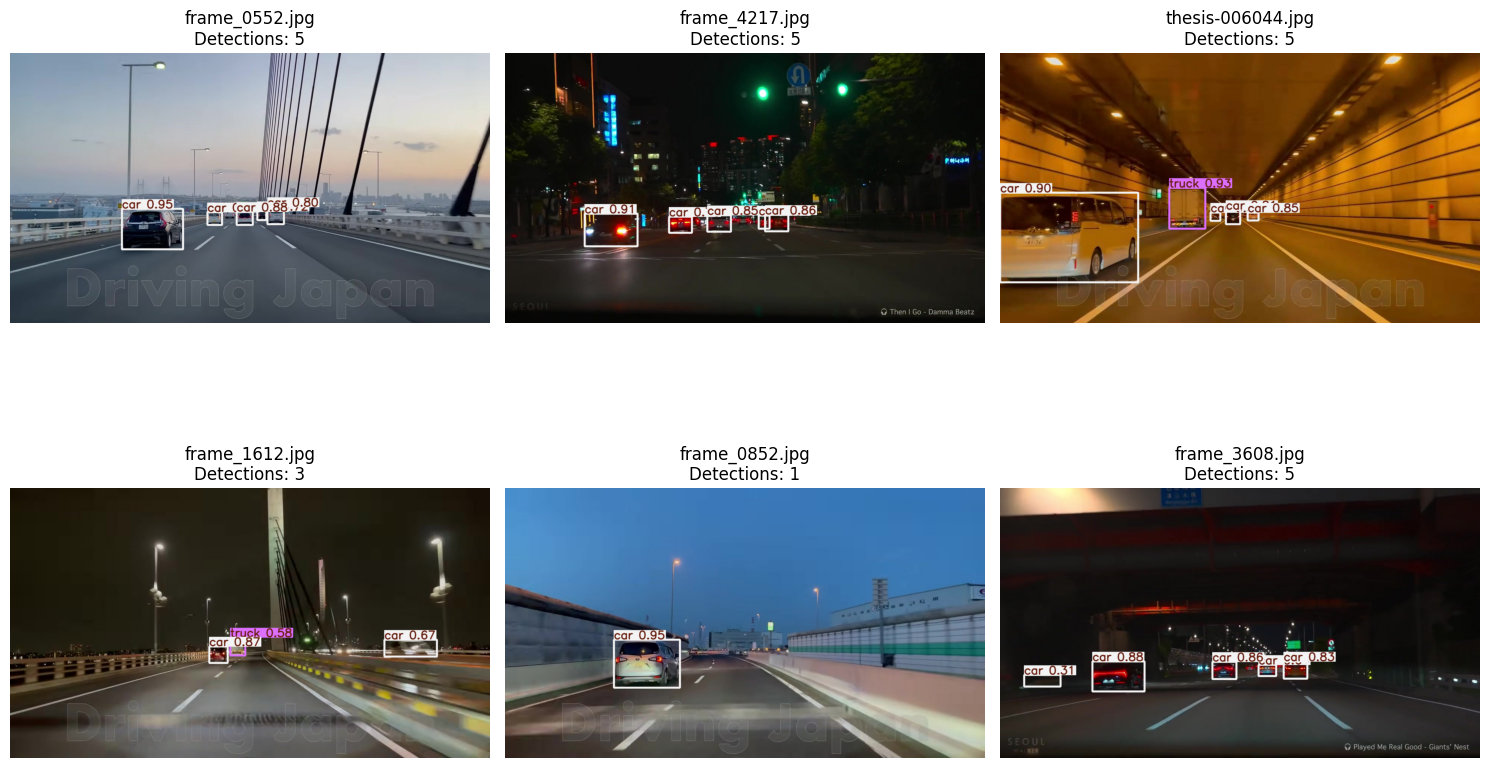


=== Detection Statistics ===
Total images processed: 1067
Total detections: 5296

Detections per class:
  car: 3216
  truck: 320
  bus: 358
  motorcycle: 235
  person: 622
  other-vehicle: 362
  bicycle: 84
  stop sign: 50
  Speed limit 80km-h: 22
  green light: 12
  Speed limit 50km-h: 9
  Speed limit 60km-h: 5
  Speed limit 70km-h: 1


In [13]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load model
model = YOLO('models/train/weights/best.pt')

# Define test images directory
test_dir = Path('dataset/test/images')
if not test_dir.exists():
    print(f"Test directory {test_dir} not found!")
    exit()

# Get all image files
image_files = []
for ext in ['*.jpg', '*.jpeg', '*.png']:
    image_files.extend(list(test_dir.glob(ext)))

# Select up to 6 images for visualization
n_images_to_show = min(6, len(image_files))
selected_images = image_files[:n_images_to_show]

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Process each selected image
for idx, img_path in enumerate(selected_images):
    # Read and process image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run inference with batch=1
    results = model.predict(source=img, batch=1, verbose=False)
    result = results[0]

    # Draw boxes on the image
    annotated_img = result.plot()

    # Display image
    axes[idx].imshow(annotated_img)
    axes[idx].set_title(f'{img_path.name}\nDetections: {len(result.boxes)}')
    axes[idx].axis('off')

# Hide any unused subplots
for idx in range(len(selected_images), 6):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# === Detection Statistics for all test images ===
print("\n=== Detection Statistics ===")
total_detections = 0
class_counts = {}

for img_path in image_files:
    results = model.predict(source=str(img_path), batch=1, verbose=False)
    result = results[0]

    for box in result.boxes:
        cls = int(box.cls[0].item())  # get class index
        cls_name = model.names.get(cls, f'class_{cls}')
        class_counts[cls_name] = class_counts.get(cls_name, 0) + 1
        total_detections += 1

print(f"Total images processed: {len(image_files)}")
print(f"Total detections: {total_detections}\n")

print("Detections per class:")
for cls_name, count in class_counts.items():
    print(f"  {cls_name}: {count}")
